# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Descriptive Statistics](#descriptive)
- [Part II - Probability](#probability)
- [Part III - Experimentation](#experimentation)
- [Part IV - Algorithms](#algorithms)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  For this project, I analyzed the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='descriptive'></a>
#### Part I - Descriptive Statistics

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure we get the same results
random.seed(0)

Read in the `ab_data.csv` data. Store it in `df`. Take a look at the top few rows here.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,country,group,converted
0,UK,control,0
1,US,treatment,1
2,UK,treatment,0
3,UK,control,0
4,UK,treatment,0


Find the number of rows in the dataset.

In [3]:
df.shape

(69889, 3)

Check for missing values

In [4]:
df.isnull().sum()

country      0
group        0
converted    0
dtype: int64

Recognize that all of the columns are of a categorical data type with the exception of one.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69889 entries, 0 to 69888
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    69889 non-null  object
 1   group      69889 non-null  object
 2   converted  69889 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


The "converted" column is not categorical.

The 'converted' column contains binary values (1 or 0). It makes sense that 0 and 1 are the only possible values for the this column because this is a binary outcome. Either the user purchases (1) or they do not (0). There are no other logical possibilities

In [6]:
df.head()

,country,group,converted
0,UK,control,0
1,US,treatment,1
2,UK,treatment,0
3,UK,control,0
4,UK,treatment,0


The proportion of users converted.

In [7]:
np.mean(df['converted'])

np.float64(0.13047832992316388)

Find the number of customers from each country. Build a bar chart to show the count of visits from each country.

In [8]:
# number of visitors from each country - pull the necessary code from the next cell to provide just the counts
df['country'].value_counts()

country
US    48850
UK    17551
CA     3488
Name: count, dtype: int64

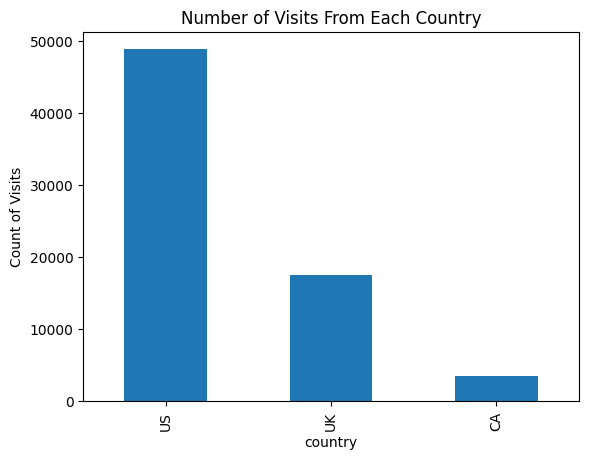

In [9]:
# bar chart of results - this part is done for you
df['country'].value_counts().plot(kind='bar');
plt.title('Number of Visits From Each Country');
plt.ylabel('Count of Visits');
plt.show();

<a id='probability'></a>
#### Part II - Probability

Let's look more at how different factors are related to `converting`.

What is the probability of an individual converting regardless of the page they receive or the country they are from? Simply, what is the chance of conversion in the dataset?

In [10]:
np.mean(df['converted'])

np.float64(0.13047832992316388)

Given that an individual was in the `control` group, what is the probability they converted?

In [11]:
df.query('group == "control"')['converted'].mean()

np.float64(0.1052540515600669)

Given that an individual was in the `treatment` group, what is the probability they converted?

In [12]:
df.query('group == "treatment"')['converted'].mean()

np.float64(0.15532078043793132)

There's evidence that the `treatment` is related to higher `converted` rates. The probability an individual in the `treatment` group convert is `0.155`, higher than the conversion rate of `0.105` for the `control` group.

The probability that an individual was in the `treatment`:

In [13]:
np.mean(df['group'] == 'treatment')

np.float64(0.5038131894861853)

The probability that an individual was from Canada `CA`:

In [14]:
np.mean(df['country'] == 'CA')

np.float64(0.04990771079855199)

Given that an individual was in the `US`, what was the probability that they `converted`?

$P(\text{converted} == 1|\text{country} ==\text{"US"})$

In [15]:
df.query('country == "US"')['converted'].mean()

np.float64(0.13277379733879222)

Given that an individual was in the `UK`, what was the probability that they `converted`? 

$P(\text{converted} == 1|\text{country} ==\text{"UK"})$

In [16]:
df.query('country == "UK"')['converted'].mean()

np.float64(0.12512107572218106)

There's evidence that the `converted` rate might differ from one country to the next. The converted rate for the `US` is `0.133`, slightly higher than the coverted rate for `UK` which is `0.125`.

The conversion rates of the 2 groups in the US can be written as:

$P(\text{converted} == 1|(\text{country} ==\text{"US" AND }\text{group} ==\text{"control"})) = 10.7\%$

$P(\text{converted} == 1|(\text{country} ==\text{"US" AND }\text{group} ==\text{"treatment"})) = 15.8\%$

Two methods for calculating the conversion rates of the 2 groups in the US:

In [17]:
# Method 1  - explicitly calculate each probability
print(df.query('country == "US" and group == "control" and converted == 1').shape[0]/df.query('country == "US" and group == "control"').shape[0]) 
print(df.query('country == "US" and group == "treatment" and converted == 1').shape[0]/df.query('country == "US" and group == "treatment"').shape[0])

0.10731404958677686
0.1577687626774848


In [18]:
# Method 2 - quickly calculate using `groupby`
df.query('country == "US"').groupby('group')['converted'].mean()

group
control      0.107314
treatment    0.157769
Name: converted, dtype: float64

In [19]:
# UK conversion rate by group
df.query('country == "UK"').groupby('group')['converted'].mean()

group
control      0.101649
treatment    0.148698
Name: converted, dtype: float64

In [20]:
# CA conversion rate by group
df.query('country == "CA"').groupby('group')['converted'].mean()

group
control      0.094474
treatment    0.154017
Name: converted, dtype: float64

The table below shows the conversion rates by country and treatment group.  

|             | US          | UK          | CA          |
| ----------- | ----------- | ----------- | ----------- |
| Control     | 10.7%       | 10.2%       | 9.4%        |
| Treatment   | 15.8%       | 14.9%       | 15.4%       |

It appears that there could be an interaction between how country and treatment impact conversion.

<a id='experimentation'></a>
### Part III - Experimentation

Assume that the control page is better unless the treatment page proves to be definitely better at a Type I error rate of 5%, we state our null and alternative hypotheses in terms of **$p_{control}$** and **$p_{treatment}$** as:  

$H_{0}: p_{control} >= p_{treatment}$

$H_{1}: p_{control} < p_{treatment}$

Which is equivalent to:

$H_{0}: p_{treatment} - p_{control} <= 0$

$H_{1}: p_{treatment} - p_{control} > 0$


Where  
* **$p_{control}$** is the `converted` rate for the control page
* **$p_{treatment}$** `converted` rate for the treatment page

**Note for this experiment: we are not looking at differences associated with country.**

Assume under the null hypothesis, $p_{treatment}$ and $p_{control}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{treatment}$ and $p_{control}$ are equal. Furthermore, assume they are equal to the **converted** rate in `df` regardless of the page. **These are set in the first cell below.**<br><br>

* Use a sample size for each page equal to the ones in `df`.

* Perform the sampling distribution for the difference in `converted` between the two pages over 500 iterations of calculating an estimate from the null.

The **convert rate** for $p_{treatment}$ under the null,  the **convert rate** for $p_{control}$ under the null, the sample size for the `control` and the sample size for the `treatment` are from the original dataset.

In [21]:
p_control_treatment_null  = df['converted'].mean()
n_treatment = df.query('group == "treatment"').shape[0]
n_control = df.query('group == "control"').shape[0]
print(f'The conversion rate under the null: {p_control_treatment_null}')
print(f'The sample size for the treatment group: {n_treatment}')
print(f'The sample size for the control group: {n_control}')

The conversion rate under the null: 0.13047832992316388
The sample size for the treatment group: 35211
The sample size for the control group: 34678


Simulate 500 $p_{treatment}$ - $p_{control}$ values.  Store all 500 values in an numpy array called **p_diffs**.

In [22]:
p_diffs = []
for _ in range(500):
    # simulate the treatment and control converted arrays
    treatment_converted = np.random.choice([0, 1], size=n_treatment, p=[1 - p_control_treatment_null, p_control_treatment_null])
    control_converted = np.random.choice([0, 1], size=n_control, p=[1 - p_control_treatment_null, p_control_treatment_null])
    # calculate p_treatment and p_control under the null
    p_treatment = treatment_converted.mean()
    p_control = control_converted.mean()
    # calculate the difference between p_treatment_null and p_control_null
    difference = p_treatment - p_control
    # add p_diff to the p_diffs array
    p_diffs.append(difference)
print(p_diffs[:10])

[np.float64(0.001555609988620088), np.float64(0.003041097372677992), np.float64(-0.002673839618718421), np.float64(8.049075533664296e-05), np.float64(0.005015144141971323), np.float64(0.008131256641543794), np.float64(0.00016312639115340088), np.float64(-0.0035782273675483423), np.float64(0.0013603005626340037), np.float64(0.0005130686781442684)]


Plot a histogram of the **p_diffs**. The histogram should have a bell shape.

<Axes: >

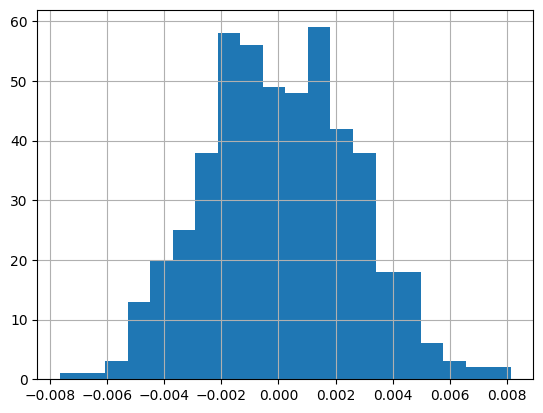

In [23]:
p_diffs = pd.Series(p_diffs)
p_diffs.hist(bins=20)

Calculate the proportion of the **p_diffs** that are greater than the difference observed between `treatment` and `control` in `df`:

In [24]:
observed_diff = df.query('group == "treatment"')['converted'].mean() - df.query('group == "control"')['converted'].mean()
greater_proportion = np.sum(p_diffs > observed_diff)/len(p_diffs)
print(greater_proportion)

0.0


In the cell above, I calculated the proportion of the 500 simulated differences that are greater than the observed difference. This value is called p-value. The p-value represents how likely it is that we would observe a difference as large or larger than the one we observed if the null hypothesis were true.  
We use Type I error rate of 0.05, which means we are willing to accept a 5% chance of rejecting the null hypothesis when it is actually true. The p-value is compared to a predetermined Type I error rate to decide whether the null hypothesis should be rejected. In this case, the p-value is 0, typically less than 0.05. This means that we reject the null hypothesis because the observed difference is unlikely to have occurred by chance.

<a id='algorithms'></a>
### Part IV - Algorithms

In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.

Since each row is either a conversion or no conversion, the appropriate regression model to use is logistic regression.

The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.  

However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [25]:
df['intercept'] = 1
df['ab_page'] = pd.get_dummies(df['group'], dtype=int)['treatment']
df.head()

,country,group,converted,intercept,ab_page
0,UK,control,0,1,0
1,US,treatment,1,1,1
2,UK,treatment,0,1,1
3,UK,control,0,1,0
4,UK,treatment,0,1,1


Create `X` matrix and `y` response column that will be passed to the model, where we are testing if there is a difference in `treatment` vs. `control`.

In [26]:
X = df[['intercept', 'ab_page']]
y = df['converted']

Use **statsmodels** to import and fit the regression model on the `X` and `y`. 

In [27]:
import statsmodels.api as sm

# Logit Model
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.384516
         Iterations 6


Provide the summary of the model below.

In [28]:
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                69889
Model:                          Logit   Df Residuals:                    69887
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Feb 2025   Pseudo R-squ.:                0.007175
Time:                        18:37:31   Log-Likelihood:                -26873.
converged:                       True   LL-Null:                       -27068.
Covariance Type:            nonrobust   LLR p-value:                 1.810e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.1402      0.017   -122.305      0.000      -2.174      -2.106
ab_page        0.4467      0.023     19.539      0.000       0.402       0.492


The p-value associated with ab_page is 0 which is the same as the p-value calculated in the Experiment section.

Now I want to create two new columns as dummy variables for `US` and `UK`.

In [29]:
### Create the necessary dummy variables
df['US'] = pd.get_dummies(df['country'], dtype=int)['US']
df['UK'] = pd.get_dummies(df['country'], dtype=int)['UK']
df.head()

,country,group,converted,intercept,ab_page,US,UK
0,UK,control,0,1,0,0,1
1,US,treatment,1,1,1,1,0
2,UK,treatment,0,1,1,0,1
3,UK,control,0,1,0,0,1
4,UK,treatment,0,1,1,0,1


Create your `X` matrix and `y` response column that will be passed to the model, where you are testing if there is 
* a difference in `converted` between `treatment` vs. `control`
* a difference in `converted` between `US`, `UK`, and `CA`

In [30]:
X = df[['intercept', 'ab_page', 'US', 'UK']] 
y = df['converted']

Use **statsmodels** to import and fit the regression model on the `X` and `y`.

In [31]:
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.384463
         Iterations 6


Provide the summary of your model below.

In [32]:
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                69889
Model:                          Logit   Df Residuals:                    69885
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Feb 2025   Pseudo R-squ.:                0.007312
Time:                        18:37:31   Log-Likelihood:                -26870.
converged:                       True   LL-Null:                       -27068.
Covariance Type:            nonrobust   LLR p-value:                 1.778e-85
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.1930      0.053    -41.308      0.000      -2.297      -2.089
ab_page        0.4466      0.023     19.534      0.000       0.402       0.491
US             0.0727      0.053      1.372      0.1

p-values associatead with US and UK are both greater than 0.05. This means that US and UK have insignificant impact on the conversion rate.